**Step 1: Import packages**

In [34]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
import kerastuner as kt
import IPython

# sklearn libraries for preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# sklearn libraries for models
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from kerastuner import HyperModel
from kerastuner import Hyperband

# sklearn libraries for evaluation
from sklearn import metrics

**Step 2: Define working directories**

In [2]:
os.chdir('C:/Users/user/Documents/Berkeley_MIDS/W207_Machine_Learning/w207_final_project')
#os.chdir('/Users/alyssaaugsburger/Documents/Berkeley_MIDS/W207/Final_Project')

**Step 3: Define classes**

In [ ]:
# Clear the training outputs at the end of every step
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        '''Clear the training outputs at the end of every step for the Keras Tuner'''
        IPython.display.clear_output(wait = True)

**Step 4: Define functions**

In [3]:
def reduce(X, n):
    '''PCA dimensionality reduction for X array and n principal components'''
    pca = PCA(n_components = n) 
    X_reduced = pca.fit_transform(X)
    return X_reduced

In [4]:
def data_split(X, y, test_p, mini_s):
    '''Split train and test data for X,y data arrays with test_p percentage of observations in the test data and 
    mini_s number of observations in the mini_train set.'''
    # Split into train and test data
    train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=test_p, random_state=1, stratify=y)

    # Split test data into development data and training into mini train set for computation time
    dev_data, dev_labels = test_data[:int(test_data.shape[0]*0.5)], test_labels[:int(test_data.shape[0]*0.5)]
    mini_train_data, mini_train_labels = train_data[:mini_s], train_labels[:mini_s]
    print('Train data shape:', train_data.shape)
    print('Dev data shape:', dev_data.shape)
    print('Mini_train data shape:', mini_train_data.shape)
    
    return train_data, train_labels, test_data, test_labels, dev_data, dev_labels, mini_train_data, mini_train_labels

In [5]:
def log_reg(train_X, train_Y, dev_X, dev_Y):
    '''Logistic regression looping through values of C. Input train and test data and labels and funtion 
    returns list of accuracies and list of C values.'''
    c_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 2.0, 5.0]
    LR = []
    for c in c_values:
        clf = LogisticRegression(C=c, solver='liblinear', multi_class='auto')
        clf.fit(train_X, train_Y)
        clf_pred = clf.predict(dev_X)
        LR.append(round(metrics.f1_score(dev_Y, clf_pred, average='weighted'),3))

    return LR, c_values

In [6]:
def LR_accuracy_c(train_X, train_Y, dev_X, dev_Y):
    '''Calls logistic regression function and returns highest accuracy for specific value of C.'''
    accuracy_list = log_reg(train_X, train_Y, dev_X, dev_Y)[0]
    accuracy = [y for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    accuracy_index = [x for x,y in sorted(enumerate(accuracy_list), key = lambda x: x[1], reverse=True)][:1]
    C = log_reg(train_X, train_Y, dev_X, dev_Y)[1][accuracy_index[0]]
    
    return accuracy[0], C

In [7]:
def PCA_visualization(pca_vals, title, colors):
    x = [item[0] for item in pca_vals] 
    y = [item[1] for item in pca_vals] 

    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    ax.scatter(x, y, c=colors, s = 5)
    ax.grid()

In [8]:
def PCA_k_optimize(train_X, train_Y, dev_X, dev_Y, k_list):
    accuracies = []
    c_vals = []
    # Subset pixel data
    train_pixel = train_X[:, :150529]
    dev_pixel = dev_X[:, :150529]
    train_nopixel = train_X[:, 150529:]
    dev_nopixel = dev_X[:, 150529:]
    for k in k_list:
        #Scale and reduce only pixel data
        ss = StandardScaler()
        train_pixel_s = ss.fit_transform(train_pixel)
        dev_pixel_s = ss.transform(dev_pixel)
        pca = PCA(n_components = k) 
        train_pixel_reduced = pca.fit_transform(train_pixel_s)
        dev_pixel_reduced = pca.transform(dev_pixel_s)
        #Concatenate reduced pixel data back with non pixel data
        train_X_new = np.concatenate((train_nopixel, train_pixel_reduced), axis=1)
        dev_X_new = np.concatenate((dev_nopixel, dev_pixel_reduced), axis=1)
        #Obtain accuracy and optimized c value
        results = LR_accuracy_c(train_X_new, train_Y, dev_X_new, dev_Y)
        accuracies.append(results[0])
        c_vals.append(results[1])
    return accuracies, c_vals

In [ ]:
def model_builder(hp):
    '''Build a single layer dense neural network using Keras Tuner'''
    model = keras.Sequential()
  
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)

    model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
    
    model.add(keras.layers.Dense(2, activation = 'softmax'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])
  
    return model

In [112]:
def build_model(nodes, dropout_rate, lr):
    '''Build layers of a neural net'''
    
    # Begins the linear arrangment of layers
    model = tf.keras.models.Sequential([

    # First layer 
    # This is a dense layer. Nodes are fully connected.
    # Nodes is the number of nodes in the layer. This will be specified when calling the function.
    tf.keras.layers.Dense(nodes, activation='relu'),

    # Second layer
    # Uses dropout regularization by dropping a certain percentage before next layer
    # This makes it so that some of the nodes in a given layer don’t pass on their information to the next layer. 
    # This helps with computation time (less parameters) and with overfitting.
    # Each node in the second  layer has a probability equal to the specified dropout rate of being dropped from the computation of the activations of the next layer. 
    tf.keras.layers.Dropout(dropout_rate),
    
    # Third layer
    # This is the output layer. It returns a logits array of length 2 (because we have 2 classes - logo or not logo)
    # Each node contains a probability that indicates the current image belongs to one of the 2 classes
    # It uses the activation function Softmax which is the equivalent of the Sigmoid function for multiclass logits
    tf.keras.layers.Dense(2, activation='softmax')])
    
    # Compile the model using the Adam optimizer
    # The learning rate will be specified when the function is called
    model.compile(keras.optimizers.Adam(learning_rate = lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [113]:
# Fit the neural net model
# Specify the number of epochs
def fit_model(model, data, labels, epoch_num):
    history = model.fit(data, labels, epochs = epoch_num)
    return history

In [114]:
# Evaluate the neural net model
def evaluate_model(model, data, labels):
    test_loss, test_acc = model.evaluate(data, labels)
    return test_acc

**Step 5: Read data**

5.1 Load and combine pixel data files into dataframe

In [9]:
# Load npz files to combine and print content files
data_1 = np.load('et_w207_project_npz_files_5000_tmp_tmp5ocrhjnn.npz')
data_1.close

data_2 = np.load('et_w207_project_npz_files_5000_tmp_tmp092sag67.npz')
data_2.close

data_3 = np.load('et_w207_project_npz_files_5000_tmp_tmpf31_pn8p.npz')
data_3.close

data_4 = np.load('et_w207_project_npz_files_5000_tmp_tmpq5b2g4n2.npz')
data_4.close

print(data_1.files)

['arr_0', 'arr_1']


In [10]:
# Show file arr_0 example
data_1['arr_0'][:5]

array(['ozbpir-9ey6js-ggdqwo', '378ykanq', 'p366md-big834-7o23k6',
       '3zruwvl2', 'q18iae-3vnh74-79npmy'], dtype='<U20')

In [11]:
# Show file arr_1 example
data_1['arr_1'][:5]

array([[-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ],
       [ -46.939003,  -74.779   , -118.68    , ...,  -57.939003,
         -84.779   , -118.68    ],
       [ 151.061   ,  138.22101 ,  131.32    , ...,  151.061   ,
         138.22101 ,  131.32    ],
       [  -3.939003,  -66.779   ,  -96.68    , ...,   -3.939003,
         -66.779   ,  -96.68    ],
       [-103.939   , -116.779   , -123.68    , ..., -103.939   ,
        -116.779   , -123.68    ]], dtype=float32)

In [12]:
# Get number of observations in each file
print(data_1['arr_0'].shape)
print(data_2['arr_0'].shape)
print(data_3['arr_0'].shape)
print(data_4['arr_0'].shape)

(878,)
(893,)
(638,)
(1353,)


In [13]:
# Concatenate data from all files
data_key = np.concatenate((data_1['arr_0'], data_2['arr_0'], data_3['arr_0'], data_4['arr_0']))

data_pixel = np.concatenate((data_1['arr_1'], data_2['arr_1'], data_3['arr_1'], data_4['arr_1']))
print(data_pixel.shape)

(3762, 150528)


In [14]:
# Create key value pairs with attachment key and pixel array
# Standardize pixel values between 0 and 1 by dividing by 255
# Store pixel data as dataframe
data_dict = {}
for i in range(data_key.shape[0]):
    data_dict[data_key[i]] = [data_pixel[i]/255]

df_pixel = pd.DataFrame(data=data_dict)
df_pixel_t = df_pixel.transpose()
df_pixel_t.index.names = ['attachment_key']
df_pixel_t.columns = ['pixel_array']
df_pixel_t

,pixel_array
attachment_key,
ozbpir-9ey6js-ggdqwo,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."
378ykanq,"[-0.18407452, -0.29325098, -0.46541175, -0.097..."
p366md-big834-7o23k6,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3zruwvl2,"[-0.015447071, -0.26187843, -0.37913725, -0.01..."
q18iae-3vnh74-79npmy,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."
...,...
pktyig-481wyg-6gyulf,"[-0.3605451, -0.41089803, -0.38305882, -0.3644..."
zu7y3rha,"[-0.007603933, -0.05795686, -0.08501961, -0.00..."
pxcwxf-8tnpyg-8vhb9r,"[0.3022, 0.18125883, 0.12674509, 0.31004313, 0..."


5.2 Load metadata file

In [15]:
# Load excel data
df = pd.read_csv('school_project_data_set-new.csv')
df.head()

,attachment_key,size_mb,height,width,h_to_w,filename,logo
0,001lq61k,0.122520,514.0,720.0,0.713889,campus ministry on the beach.jpg,0
1,002dlirq,3.256944,4072.0,3868.0,1.052741,BIG ALS FISH FLASH UV VP PL.jpg,0
2,003qefgm,0.002522,80.0,200.0,0.400000,netix_email_studio.png,1
3,0083okjl,0.116802,600.0,600.0,1.000000,productshot2.jpg,0
4,00a957mh,0.140714,816.0,2382.0,0.342569,divine_medical_billing_inc_master.png,1


5.3 Combine pixel and metadata features in a pandas dataframe

In [16]:
# Merge dataframes by attachment key
combined_df = df.merge(df_pixel_t, on='attachment_key')
combined_df

,attachment_key,size_mb,height,width,h_to_w,filename,logo,pixel_array
0,00xjny6u,0.011849,520.0,506.0,1.027668,Esterdale Theatre - Logo.png,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
1,04o31jop,0.012610,269.0,396.0,0.679293,BLUE_LOGO.png,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
2,0840h7ox,0.399114,518.0,920.0,0.563044,ZEN_LB-5.jpg,0,"[0.106121555, 0.05576863, 0.052235294, 0.09043..."
3,0awudx2h,0.011226,200.0,200.0,1.000000,article central 200.jpg,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
4,0bb8y85h,0.263813,885.0,800.0,1.106250,1116-100_WGTank_white.jpg,0,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
...,...,...,...,...,...,...,...,...
3750,zu7y3rha,0.147371,498.0,702.0,0.709402,journalism.jpg,0,"[-0.007603933, -0.05795686, -0.08501961, -0.00..."
3751,zuanbsqe,0.580392,206.0,415.0,0.496386,2013 05 26_techstars_id_final_bug solo graysca...,1,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3752,zw9234v4,2.021135,1645.0,1450.0,1.134483,SPIN N GLO SILVER WING GPK MY.jpg,0,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,..."
3753,zxfqbfj1,0.012057,36.0,345.0,0.104348,cornerstone web logo medium.png,1,"[-0.40760392, -0.45795685, -0.4850196, -0.4076..."


In [17]:
### VISUALIZATIONS FROM PANDAS PROFILING HERE

**Step 6: Data preprocessing**

6.1 Remove null values

In [18]:
# Remove rows with null values
combined_df = combined_df[combined_df.height.notnull()]
combined_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3754 entries, 0 to 3754
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   attachment_key  3754 non-null   object 
 1   size_mb         3754 non-null   float64
 2   height          3754 non-null   float64
 3   width           3754 non-null   float64
 4   h_to_w          3754 non-null   float64
 5   filename        3754 non-null   object 
 6   logo            3754 non-null   int64  
 7   pixel_array     3754 non-null   object 
dtypes: float64(4), int64(1), object(3)
memory usage: 264.0+ KB


6.2 Create file type dummy variables from file name

In [19]:
# Find file types from filename
file_types = []
for item in combined_df['filename']:
    file_types.append(item[-3:].lower())

print(set(file_types))

{'pig', 'peg', '73e', 'age', 'png', 'jpg', 'jpe', 'lue', 'ite', 'ack', '0mm', 'hot'}


In [20]:
# Create list of file types from filename to append to df
filetype_encoding = []
for item in combined_df['filename']:
    if item[-3:].lower() == 'jpg':
        filetype_encoding.append('jpg')
    elif item[-3:].lower() == 'png':
        filetype_encoding.append('png')
    else:
        filetype_encoding.append('other')

In [21]:
# Create df that includes column for file type
combined_df['filetype'] = filetype_encoding
combined_df = combined_df[['attachment_key', 'size_mb', 'height', 'width', 'h_to_w', 'filetype', 'pixel_array', 'filename','logo']]
combined_df.head()
#warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

/Users/alyssaaugsburger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,attachment_key,size_mb,height,width,h_to_w,filetype,pixel_array,filename,logo
0,00xjny6u,0.011849,520.0,506.0,1.027668,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",Esterdale Theatre - Logo.png,1
1,04o31jop,0.012610,269.0,396.0,0.679293,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",BLUE_LOGO.png,1
2,0840h7ox,0.399114,518.0,920.0,0.563044,jpg,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",ZEN_LB-5.jpg,0
3,0awudx2h,0.011226,200.0,200.0,1.000000,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",article central 200.jpg,1
4,0bb8y85h,0.263813,885.0,800.0,1.106250,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",1116-100_WGTank_white.jpg,0


In [22]:
# Get dummies for file type
filetype_dummies = pd.get_dummies(combined_df.filetype)

# add to initial df
combined_df = pd.concat((combined_df, filetype_dummies), axis=1)

# print head of df
combined_df.head()

,attachment_key,size_mb,height,width,h_to_w,filetype,pixel_array,filename,logo,jpg,other,png
0,00xjny6u,0.011849,520.0,506.0,1.027668,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",Esterdale Theatre - Logo.png,1,0,0,1
1,04o31jop,0.012610,269.0,396.0,0.679293,png,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",BLUE_LOGO.png,1,0,0,1
2,0840h7ox,0.399114,518.0,920.0,0.563044,jpg,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",ZEN_LB-5.jpg,0,1,0,0
3,0awudx2h,0.011226,200.0,200.0,1.000000,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",article central 200.jpg,1,1,0,0
4,0bb8y85h,0.263813,885.0,800.0,1.106250,jpg,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",1116-100_WGTank_white.jpg,0,1,0,0


6.3 Scale metadata variables

In [23]:
# Scale continuous feature variables
combined_df['size_mb'] = preprocessing.scale(combined_df['size_mb'])
combined_df['h_to_w'] = preprocessing.scale(combined_df['h_to_w'])
combined_df['height'] = preprocessing.scale(combined_df['height'])
combined_df['width'] = preprocessing.scale(combined_df['width'])

6.4 Create X, y arrays

In [24]:
# Organize df to separate into feature arrays
combined_df = combined_df[['attachment_key', 'pixel_array', 'size_mb', 'h_to_w', 'jpg', 'png', 'other',
                                     'height', 'width', 'logo', 'filetype', 'filename']]
combined_df.head()

,attachment_key,pixel_array,size_mb,h_to_w,jpg,png,other,height,width,logo,filetype,filename
0,00xjny6u,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366308,0.638439,0,1,0,-0.712708,-0.888611,1,png,Esterdale Theatre - Logo.png
1,04o31jop,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366187,-0.187892,0,1,0,-0.861519,-0.943446,1,png,BLUE_LOGO.png
2,0840h7ox,"[0.106121555, 0.05576863, 0.052235294, 0.09043...",-0.304882,-0.463630,1,0,0,-0.713894,-0.682232,0,jpg,ZEN_LB-5.jpg
3,0awudx2h,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.366407,0.572811,1,0,0,-0.902427,-1.041152,1,jpg,article central 200.jpg
4,0bb8y85h,"[0.5923961, 0.54204315, 0.51498044, 0.5923961,...",-0.326343,0.824832,1,0,0,-0.496310,-0.742052,0,jpg,1116-100_WGTank_white.jpg


In [25]:
# y array contains logo/not logo binary variable
y = np.array(combined_df.iloc[:, 9])

# X array contains pixel array only
X = np.array(combined_df['pixel_array'].tolist())
print(X.shape)


(3754, 150528)


In [27]:
# Reduce dimensionality of pixel array
ss_pixel = StandardScaler()
XS = ss_pixel.fit_transform(X)
pixel_reduced = reduce(XS,2)
X_reduced = pixel_reduced

nopixel_X = np.array(combined_df.iloc[:, 2:7].values)
ss_nopixel = StandardScaler()
nopixel_XS = ss_nopixel.fit_transform(nopixel_X)
nopixel_reduced = reduce(nopixel_XS,2)

combined_X = np.concatenate((nopixel_X, X), axis = 1)
ss_combined = StandardScaler()
combined_XS = ss_nopixel.fit_transform(combined_X)
combined_reduced = reduce(combined_XS,2)

colors = ['r' if label == 0 else 'g' for label in y]

In [ ]:
PCA_visualization(pixel_reduced,'PCA - Pixel Only', colors)
PCA_visualization(nopixel_reduced,'PCA - No Pixel Data', colors)
PCA_visualization(combined_reduced,'PCA - Pixel and Other Data', colors)


6.6 Create alternate X arrays with metadata features

In [28]:
# Create variations of X array with reduced pixel data and different metadata features

# X2 array contains pixel features, size, height, width, h_to_w, filetype dummies
X2 = np.concatenate((pixel_reduced, np.array(combined_df.iloc[:, 2:9])),axis=1)
print(X2.shape)

# X3 array contains pixel features, size, h_to_w, filetype dummies
X3 = np.concatenate((pixel_reduced, np.array(combined_df.iloc[:, 2:7])),axis=1)
print(X3.shape)

# X4 array contains pixel array, size, h_to_w
X4 = np.concatenate((pixel_reduced, np.array(combined_df.iloc[:, 2:4])),axis=1)
print(X4.shape)

# X5 array contains pixel array, filetype dummies 
X5 = np.concatenate((pixel_reduced, np.array(combined_df.iloc[:, 4:7])),axis=1)
print(X5.shape)

# X6 array contains size, height, width, h_to_w, filetype
X6 = np.array(combined_df.iloc[:, 2:9])
print(X6.shape)

# X7 array contains size, h_to_w, filetype
X7 = np.array(combined_df.iloc[:, 2:7])
print(X7.shape)

# X8 array contains full pixel array, size, h_to_w, filetype
X8 = np.concatenate((X, X7), axis=1)
print(X8.shape)

(3754, 9)
(3754, 7)
(3754, 4)
(3754, 5)
(3754, 7)
(3754, 5)
(3754, 150533)


6.7 Split each set of features into train, development, and test data

In [29]:
# Split all feature combinations into train, test data
train_data, train_labels, test_data, test_labels, dev_data, dev_labels, mini_train_data, mini_train_labels = data_split(X_reduced, y, 0.4, 100)
train_data2, train_labels2, test_data2, test_labels2, dev_data2, dev_labels2, mini_train_data2, mini_train_labels2 = data_split(X2, y, 0.4, 100)
train_data3, train_labels3, test_data3, test_labels3, dev_data3, dev_labels3, mini_train_data3, mini_train_labels3 = data_split(X3, y, 0.4, 100)
train_data4, train_labels4, test_data4, test_labels4, dev_data4, dev_labels4, mini_train_data4, mini_train_labels4 = data_split(X4, y, 0.4, 100)
train_data5, train_labels5, test_data5, test_labels5, dev_data5, dev_labels5, mini_train_data5, mini_train_labels5 = data_split(X5, y, 0.4, 100)
train_data6, train_labels6, test_data6, test_labels6, dev_data6, dev_labels6, mini_train_data6, mini_train_labels6 = data_split(X6, y, 0.4, 100)
train_data7, train_labels7, test_data7, test_labels7, dev_data7, dev_labels7, mini_train_data7, mini_train_labels7 = data_split(X7, y, 0.4, 100)
train_data8, train_labels8, test_data8, test_labels8, dev_data8, dev_labels8, mini_train_data8, mini_train_labels8 = data_split(X8, y, 0.4, 100)

Train data shape: (2252, 2)
Dev data shape: (751, 2)
Mini_train data shape: (100, 2)
Train data shape: (2252, 9)
Dev data shape: (751, 9)
Mini_train data shape: (100, 9)
Train data shape: (2252, 7)
Dev data shape: (751, 7)
Mini_train data shape: (100, 7)
Train data shape: (2252, 4)
Dev data shape: (751, 4)
Mini_train data shape: (100, 4)
Train data shape: (2252, 5)
Dev data shape: (751, 5)
Mini_train data shape: (100, 5)
Train data shape: (2252, 7)
Dev data shape: (751, 7)
Mini_train data shape: (100, 7)
Train data shape: (2252, 5)
Dev data shape: (751, 5)
Mini_train data shape: (100, 5)
Train data shape: (2252, 150533)
Dev data shape: (751, 150533)
Mini_train data shape: (100, 150533)


**Step 7: Logistic Regression**

7.1 Run logistic regression for pixel data only

In [ ]:
# Pixel array only
# Run LR and output best accuracy with c value
print('Features: pixel features only\nBest Accuracy: {}, c={}'.format(
    LR_accuracy_c(train_data, train_labels, dev_data, dev_labels)[0],
    LR_accuracy_c(train_data, train_labels, dev_data, dev_labels)[1]))

7.2 Run logistic regression for all feature combinations

In [61]:
# Run LR and output best accuracies with c values for each combination of features
print('Features: pixel features, size, height, width, h_to_w, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data2, train_labels2, dev_data2, dev_labels2)[0],
    LR_accuracy_c(train_data2, train_labels2, dev_data2, dev_labels2)[1]))

print('Features: pixel features, size, h_to_w, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data3, train_labels3, dev_data3, dev_labels3)[0],
    LR_accuracy_c(train_data3, train_labels3, dev_data3, dev_labels3)[1]))

print('Features: pixel features, size, h_to_w\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data4, train_labels4, dev_data4, dev_labels4)[0],
    LR_accuracy_c(train_data4, train_labels4, dev_data4, dev_labels4)[1]))

print('Features: pixel features, filetype dummies\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data5, train_labels5, dev_data5, dev_labels5)[0],
    LR_accuracy_c(train_data5, train_labels5, dev_data5, dev_labels5)[1]))

print('Features: size, height, width, h_to_w, filetype\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data6, train_labels6, dev_data6, dev_labels6)[0],
    LR_accuracy_c(train_data6, train_labels6, dev_data6, dev_labels6)[1]))

print('Features: size, h_to_w, filetype\nBest Accuracy: {}, c={}\n'.format(
    LR_accuracy_c(train_data7, train_labels7, dev_data7, dev_labels7)[0],
    LR_accuracy_c(train_data7, train_labels7, dev_data7, dev_labels7)[1]))

Features: pixel features, size, height, width, h_to_w, filetype dummies
Best Accuracy: 0.858, c=0.1

Features: pixel features, size, h_to_w, filetype dummies
Best Accuracy: 0.849, c=2.0

Features: pixel features, size, h_to_w
Best Accuracy: 0.768, c=0.3

Features: pixel features, filetype dummies
Best Accuracy: 0.822, c=0.2

Features: size, height, width, h_to_w, filetype
Best Accuracy: 0.845, c=0.1

Features: size, h_to_w, filetype
Best Accuracy: 0.849, c=0.01



In [37]:
#Determine best k value for PCA of pixel data
k_list = [i for i in range(1,15)]
logreg_results = PCA_k_optimize(train_data8, train_labels8, dev_data8, dev_labels8, k_list)
accuracies = logreg_results[0]
c_vals = logreg_results[1]
max_index = accuracies.index(max(accuracies))
max_acc = accuracies[max_index]
max_c = c_vals[max_index]
max_k = k_list[max_index]
print('Features: pixel array reduced to {0} dimensions, size, h_to_w, filetype\nBest Accuracy: {1}, c={2}\n'.format(max_k, max_acc, max_c))

Features: pixel array reduced to 1 dimensions, size, h_to_w, filetype
Best Accuracy: 0.861, c=0.1



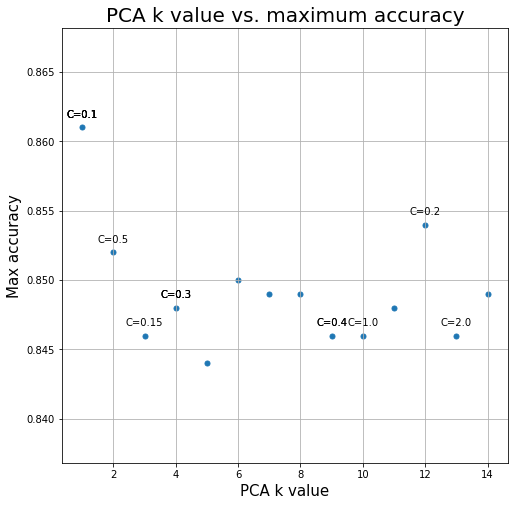

In [49]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PCA k value', fontsize = 15)
ax.set_ylabel('Max accuracy', fontsize = 15)
ax.set_title("PCA k value vs. maximum accuracy", fontsize = 20)
ax.scatter(k_list, accuracies, s = 25)
for c in c_vals:
    plt.annotate("C={}".format(c), (k_list[c_vals.index(c)], accuracies[c_vals.index(c)]), textcoords="offset points", xytext=(0,10), ha='center')
ax.grid()

**Step 8: Multilayer NN**

8.1 Build a single-layer dense neural network using Keras Tuner so that we can easily tune the hyperparameters.

In [35]:
# Instantiate the tuner to perform hypertuning using the Hyperband tuner and the model_builder function we defined initially.
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = '/Users/alyssaaugsburger/Documents/Berkeley_MIDS/W207/Final_Project',
                     project_name = 'keras_tuner_results')    

In [38]:
# Run the hyperparameter search
tuner.search(train_data, train_labels, epochs = 10, validation_data = (dev_data,dev_labels), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

# Print the results
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.0001.



In [40]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.fit(train_data, train_labels, epochs = 10, validation_data = (dev_data, dev_labels))

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 0.7506 - accuracy: 0.53 - ETA: 0s - loss: 0.7391 - accuracy: 0.56 - 0s 2ms/step - loss: 0.7409 - accuracy: 0.5599 - val_loss: 0.7363 - val_accuracy: 0.5686
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 0.7517 - accuracy: 0.56 - ETA: 0s - loss: 0.6753 - accuracy: 0.60 - 0s 1ms/step - loss: 0.6705 - accuracy: 0.6128 - val_loss: 0.6655 - val_accuracy: 0.6285
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.68 - ETA: 0s - loss: 0.6523 - accuracy: 0.64 - 0s 1ms/step - loss: 0.6519 - accuracy: 0.6430 - val_loss: 0.6549 - val_accuracy: 0.6312
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.75 - ETA: 0s - loss: 0.6375 - accuracy: 0.64 - 0s 1ms/step - loss: 0.6358 - accuracy: 0.6510 - val_loss: 0.6447 - val_accuracy: 0.6418
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.6399 - accuracy: 0.62 - ETA: 0s - 

8.2 Build a multi-layer dense neural network.

In [70]:
# Run an intial model using the parameters from the Keras Tuner model and an intial dropout rate of .2
build_model_output = build_model(384, .2, .0001)
fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 50)
final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
print(final_accuracy)

Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 17.7482 - accuracy: 0.468 - ETA: 0s - loss: 12.1404 - accuracy: 0.539 - 0s 992us/step - loss: 10.3425 - accuracy: 0.5413
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 3.5368 - accuracy: 0.59 - ETA: 0s - loss: 3.9771 - accuracy: 0.57 - 0s 1ms/step - loss: 4.1478 - accuracy: 0.5653
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.6871 - accuracy: 0.68 - ETA: 0s - loss: 3.8072 - accuracy: 0.58 - 0s 968us/step - loss: 3.9152 - accuracy: 0.5861
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 5.0047 - accuracy: 0.50 - ETA: 0s - loss: 3.8582 - accuracy: 0.57 - 0s 960us/step - loss: 3.8989 - accuracy: 0.5830
Epoch 5/50
71/71 [==============================] - ETA: 0s - loss: 3.2401 - accuracy: 0.62 - ETA: 0s - loss: 3.7560 - accuracy: 0.57 - 0s 963us/step - loss: 3.7446 - accuracy: 0.5768
Epoch 6/50
71/71 [==============================] - ETA: 0s - loss: 3.3498 - 

71/71 [==============================] - ETA: 0s - loss: 1.6839 - accuracy: 0.65 - ETA: 0s - loss: 1.4201 - accuracy: 0.71 - 0s 918us/step - loss: 1.4166 - accuracy: 0.7145
Epoch 46/50
71/71 [==============================] - ETA: 0s - loss: 1.5288 - accuracy: 0.71 - ETA: 0s - loss: 1.4450 - accuracy: 0.70 - 0s 897us/step - loss: 1.4200 - accuracy: 0.7056
Epoch 47/50
71/71 [==============================] - ETA: 0s - loss: 1.4837 - accuracy: 0.71 - ETA: 0s - loss: 1.4456 - accuracy: 0.71 - 0s 921us/step - loss: 1.3933 - accuracy: 0.7145
Epoch 48/50
71/71 [==============================] - ETA: 0s - loss: 1.2029 - accuracy: 0.68 - ETA: 0s - loss: 1.4114 - accuracy: 0.73 - 0s 906us/step - loss: 1.4262 - accuracy: 0.7300
Epoch 49/50
71/71 [==============================] - ETA: 0s - loss: 1.0987 - accuracy: 0.78 - ETA: 0s - loss: 1.1889 - accuracy: 0.74 - 0s 978us/step - loss: 1.2032 - accuracy: 0.7429
Epoch 50/50
24/24 [==============================] - ETA: 0s - loss: 0.5222 - accuracy:

8.3 Tune the hyperparameters to try and improve the accuracy.

In [78]:
# Optimize dropout rate
# Loop through dropout rates
dropout_list = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
final_accuracy_dropout_list = []

for i in dropout_list:
    build_model_output = build_model(384, i, .0001)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_dropout_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 14.3289 - accuracy: 0.468 - ETA: 0s - loss: 5.3827 - accuracy: 0.501 - 0s 969us/step - loss: 4.7276 - accuracy: 0.5266
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 3.7875 - accuracy: 0.37 - ETA: 0s - loss: 3.0881 - accuracy: 0.58 - 0s 945us/step - loss: 3.0053 - accuracy: 0.5915
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 3.4592 - accuracy: 0.46 - ETA: 0s - loss: 3.0511 - accuracy: 0.57 - 0s 1ms/step - loss: 3.0293 - accuracy: 0.5719
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 2.3750 - accuracy: 0.65 - ETA: 0s - loss: 2.8806 - accuracy: 0.57 - 0s 954us/step - loss: 2.8475 - accuracy: 0.5839
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 1.1347 - accuracy: 0.71 - 0s 725us/step - loss: 1.4259 - accuracy: 0.6245
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 7.4437 - accuracy: 0.46 - ETA: 0s - loss: 5.2540 - accuracy

24/24 [==============================] - ETA: 0s - loss: 4.8334 - accuracy: 0.68 - 0s 820us/step - loss: 6.6237 - accuracy: 0.6192
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 27.7425 - accuracy: 0.531 - ETA: 0s - loss: 27.2521 - accuracy: 0.523 - 0s 965us/step - loss: 26.3546 - accuracy: 0.5280
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 25.1548 - accuracy: 0.593 - ETA: 0s - loss: 23.3568 - accuracy: 0.544 - 0s 902us/step - loss: 22.4850 - accuracy: 0.5520
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 17.3419 - accuracy: 0.656 - ETA: 0s - loss: 20.0826 - accuracy: 0.556 - 0s 841us/step - loss: 20.5965 - accuracy: 0.5560
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 23.4458 - accuracy: 0.468 - ETA: 0s - loss: 21.1349 - accuracy: 0.554 - 0s 826us/step - loss: 21.2899 - accuracy: 0.5546
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 6.2735 - accuracy: 0.68 - 0s 700us/step - loss: 8.

Text(0, 0.5, 'Accuracy')

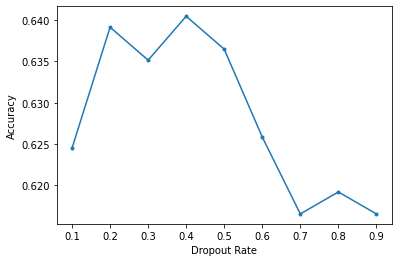

In [80]:
# Graph results
plt.plot(dropout_list, final_accuracy_dropout_list, marker = ".")
plt.xlabel('Dropout Rate')
plt.ylabel('Accuracy')

In [81]:
# Optimize learning rate
# Loop through learning rates
learning_rate_list = [.000001, .00001, .0001, .001, .01, .1]
final_accuracy_learning_list = []

for i in learning_rate_list:
    build_model_output = build_model(384, .4, i)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_learning_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 12.4117 - accuracy: 0.406 - ETA: 0s - loss: 10.6756 - accuracy: 0.459 - 0s 971us/step - loss: 10.6652 - accuracy: 0.4605
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 3.9994 - accuracy: 0.46 - ETA: 0s - loss: 9.6808 - accuracy: 0.48 - 0s 945us/step - loss: 9.3486 - accuracy: 0.4951
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 7.0511 - accuracy: 0.65 - ETA: 0s - loss: 9.8283 - accuracy: 0.47 - 0s 979us/step - loss: 9.9090 - accuracy: 0.4645
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 8.4655 - accuracy: 0.46 - ETA: 0s - loss: 9.5427 - accuracy: 0.48 - 0s 977us/step - loss: 9.8051 - accuracy: 0.4862
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 3.2294 - accuracy: 0.46 - 0s 763us/step - loss: 3.2537 - accuracy: 0.4847
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 21.9346 - accuracy: 0.468 - ETA: 0s - loss: 24.0070 - a

Text(0, 0.5, 'Accuracy')

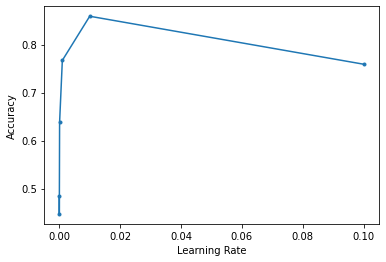

In [83]:
# Graph results
plt.plot(learning_rate_list, final_accuracy_learning_list, label = "Predicted Accuracies", marker = ".")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

In [84]:
# Try different numbers of nodes - keeping dropout at .4 and learning rate at .0001

#Loop through nodes
final_accuracy_node_list = []

for i in range(1, 550, 50):
    build_model_output = build_model(i, .4, .01)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 39.7880 - accuracy: 0.437 - 0s 693us/step - loss: 29.6574 - accuracy: 0.4045
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 6.5815 - accuracy: 0.31 - 0s 652us/step - loss: 1.9835 - accuracy: 0.4343
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.6763 - accuracy: 0.62 - 0s 674us/step - loss: 0.6786 - accuracy: 0.5924
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.62 - 0s 663us/step - loss: 0.6782 - accuracy: 0.5906
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.59 - 0s 672us/step - loss: 0.6833 - accuracy: 0.5686
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 18.5009 - accuracy: 0.687 - ETA: 0s - loss: 6.0067 - accuracy: 0.591 - 0s 776us/step - loss: 5.8458 - accuracy: 0.5946
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.9514 - accuracy: 0.65 - ETA: 0s - los

71/71 [==============================] - ETA: 0s - loss: 10.9356 - accuracy: 0.593 - ETA: 0s - loss: 9.7149 - accuracy: 0.601 - 0s 955us/step - loss: 8.3362 - accuracy: 0.6137
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 1.5352 - accuracy: 0.75 - ETA: 0s - loss: 1.5760 - accuracy: 0.68 - 0s 896us/step - loss: 1.4388 - accuracy: 0.6958
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.68 - ETA: 0s - loss: 0.6122 - accuracy: 0.75 - 0s 976us/step - loss: 0.6018 - accuracy: 0.7571
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.75 - ETA: 0s - loss: 0.5585 - accuracy: 0.77 - 0s 876us/step - loss: 0.5479 - accuracy: 0.7735
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.2147 - accuracy: 0.93 - 0s 734us/step - loss: 0.3899 - accuracy: 0.8349
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 9.2868 - accuracy: 0.43 - ETA: 0s - loss: 10.2228 - accuracy: 0.594

Text(0, 0.5, 'Accuracy')

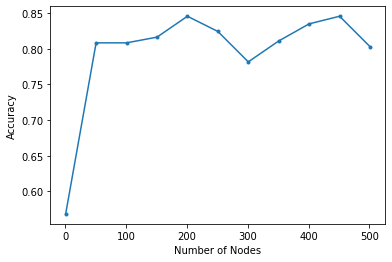

In [85]:
#Graph the results
plt.plot(range(1,550,50), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [86]:
# It looks like best value is somewhere between 200 and 500
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(200, 500, 25):
    build_model_output = build_model(i, .4, .01)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 46.0051 - accuracy: 0.312 - ETA: 0s - loss: 10.3272 - accuracy: 0.582 - 0s 945us/step - loss: 8.5985 - accuracy: 0.5968
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 0.8603 - accuracy: 0.81 - ETA: 0s - loss: 1.1397 - accuracy: 0.71 - 0s 836us/step - loss: 1.0868 - accuracy: 0.7131
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.75 - ETA: 0s - loss: 0.6746 - accuracy: 0.73 - 0s 854us/step - loss: 0.6528 - accuracy: 0.7460
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.75 - ETA: 0s - loss: 0.5253 - accuracy: 0.77 - 0s 823us/step - loss: 0.5229 - accuracy: 0.7766
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.90 - 0s 692us/step - loss: 0.3745 - accuracy: 0.8429
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 11.8812 - accuracy: 0.375 - ETA: 0s - loss: 7.7040 - acc

24/24 [==============================] - ETA: 0s - loss: 0.4265 - accuracy: 0.81 - 0s 743us/step - loss: 0.5097 - accuracy: 0.7683
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 7.9978 - accuracy: 0.65 - ETA: 0s - loss: 8.6453 - accuracy: 0.61 - 0s 998us/step - loss: 7.6033 - accuracy: 0.6208
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 2.0916 - accuracy: 0.71 - ETA: 0s - loss: 2.1565 - accuracy: 0.67 - 0s 1ms/step - loss: 1.6241 - accuracy: 0.7114
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.8908 - accuracy: 0.75 - ETA: 0s - loss: 0.8778 - accuracy: 0.74 - 0s 1ms/step - loss: 1.0368 - accuracy: 0.7296
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 1.0909 - accuracy: 0.68 - ETA: 0s - loss: 0.8406 - accuracy: 0.74 - 0s 1ms/step - loss: 0.6499 - accuracy: 0.7749
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.2318 - accuracy: 0.90 - 0s 783us/step - loss: 0.4004 - accuracy: 0.8309
Ep

Text(0, 0.5, 'Accuracy')

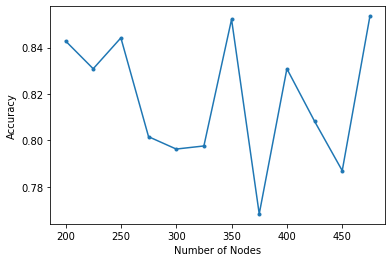

In [87]:
#Graph results
plt.plot(range(200, 500, 25), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [88]:
# It looks like best value is somewhere between 350 and 500
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(350, 500, 10):
    build_model_output = build_model(i, .4, .01)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_node_list.append(final_accuracy)


Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 19.3679 - accuracy: 0.500 - ETA: 0s - loss: 7.8462 - accuracy: 0.600 - 0s 936us/step - loss: 7.0122 - accuracy: 0.6066
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 1.2085 - accuracy: 0.71 - ETA: 0s - loss: 1.5368 - accuracy: 0.68 - 0s 941us/step - loss: 1.3603 - accuracy: 0.6998
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.8683 - accuracy: 0.75 - ETA: 0s - loss: 0.5966 - accuracy: 0.76 - 0s 938us/step - loss: 0.5941 - accuracy: 0.7611
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.75 - ETA: 0s - loss: 0.5528 - accuracy: 0.76 - 0s 1ms/step - loss: 0.5257 - accuracy: 0.7753
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.7237 - accuracy: 0.78 - 0s 802us/step - loss: 0.6652 - accuracy: 0.7377
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 24.1441 - accuracy: 0.375 - ETA: 0s - loss: 9.9866 - accura

24/24 [==============================] - ETA: 0s - loss: 0.2392 - accuracy: 0.90 - 0s 780us/step - loss: 0.4254 - accuracy: 0.8149
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 12.2342 - accuracy: 0.500 - ETA: 0s - loss: 11.2343 - accuracy: 0.609 - 0s 1ms/step - loss: 9.4044 - accuracy: 0.6155
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 1.6256 - accuracy: 0.78 - ETA: 0s - loss: 1.6220 - accuracy: 0.67 - 0s 924us/step - loss: 1.4852 - accuracy: 0.6838
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.78 - ETA: 0s - loss: 0.7487 - accuracy: 0.74 - 0s 910us/step - loss: 0.7164 - accuracy: 0.7500
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.1784 - accuracy: 0.93 - ETA: 0s - loss: 0.4937 - accuracy: 0.78 - 0s 922us/step - loss: 0.4889 - accuracy: 0.7851
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.2439 - accuracy: 0.90 - 0s 745us/step - loss: 0.3660 - accuracy: 0

Text(0, 0.5, 'Accuracy')

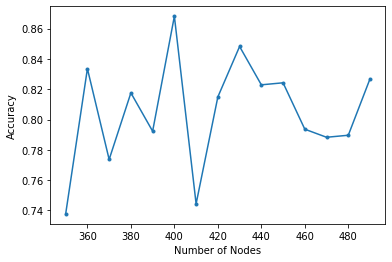

In [89]:
#Graph results
plt.plot(range(350, 500, 10), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [94]:
# It looks like best value is somewhere between 400 and 410
# Narrow this down
# Loop through nodes
final_accuracy_node_list = []

for i in range(400, 411, 1):
    build_model_output = build_model(i, .4, .01)
    fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 5)
    final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
    final_accuracy_node_list.append(final_accuracy)

Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 8.9231 - accuracy: 0.56 - ETA: 0s - loss: 6.5176 - accuracy: 0.63 - 0s 997us/step - loss: 5.6583 - accuracy: 0.6301
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 2.3208 - accuracy: 0.68 - ETA: 0s - loss: 1.9936 - accuracy: 0.67 - 0s 978us/step - loss: 1.7482 - accuracy: 0.6883
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 1.4628 - accuracy: 0.59 - ETA: 0s - loss: 0.7248 - accuracy: 0.76 - 0s 986us/step - loss: 0.6870 - accuracy: 0.7602
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.78 - ETA: 0s - loss: 0.4950 - accuracy: 0.78 - 0s 958us/step - loss: 0.4962 - accuracy: 0.7806
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.3826 - accuracy: 0.81 - 0s 699us/step - loss: 0.4395 - accuracy: 0.7896
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 6.6614 - accuracy: 0.59 - ETA: 0s - loss: 8.1864 - accuracy:

24/24 [==============================] - ETA: 0s - loss: 0.3606 - accuracy: 0.90 - 0s 778us/step - loss: 0.3957 - accuracy: 0.8429
Epoch 1/5
71/71 [==============================] - ETA: 0s - loss: 10.5858 - accuracy: 0.406 - ETA: 0s - loss: 9.1910 - accuracy: 0.585 - 0s 1ms/step - loss: 7.5102 - accuracy: 0.6057
Epoch 2/5
71/71 [==============================] - ETA: 0s - loss: 1.2530 - accuracy: 0.68 - ETA: 0s - loss: 1.6465 - accuracy: 0.69 - 0s 963us/step - loss: 1.5485 - accuracy: 0.6994
Epoch 3/5
71/71 [==============================] - ETA: 0s - loss: 0.9303 - accuracy: 0.71 - ETA: 0s - loss: 0.7202 - accuracy: 0.75 - 0s 960us/step - loss: 0.6801 - accuracy: 0.7611
Epoch 4/5
71/71 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.75 - ETA: 0s - loss: 0.5260 - accuracy: 0.78 - 0s 943us/step - loss: 0.5164 - accuracy: 0.7842
Epoch 5/5
24/24 [==============================] - ETA: 0s - loss: 0.4126 - accuracy: 0.78 - 0s 725us/step - loss: 0.4815 - accuracy: 0.

Text(0, 0.5, 'Accuracy')

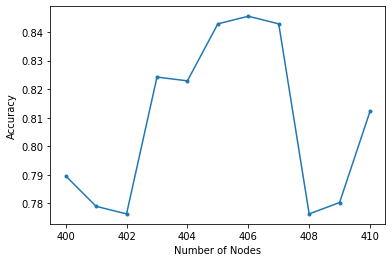

In [95]:
#Graph results
plt.plot(range(400, 411, 1), final_accuracy_node_list, marker = ".")
plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')

In [110]:
#Best value is 406. Re-run model with this value and 50 epochs, since we have tuned all the parameters.
build_model_output = build_model(406, .2, .01)
fit_model_output = fit_model(build_model_output, train_data3, train_labels3, 10)
final_accuracy = evaluate_model(build_model_output, dev_data3, dev_labels3)
print(final_accuracy)

Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 7.7689 - accuracy: 0.43 - ETA: 0s - loss: 8.7047 - accuracy: 0.60 - 0s 1ms/step - loss: 6.6478 - accuracy: 0.6252
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 0.9405 - accuracy: 0.75 - ETA: 0s - loss: 1.2204 - accuracy: 0.70 - 0s 970us/step - loss: 1.1058 - accuracy: 0.7194
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.68 - ETA: 0s - loss: 0.7363 - accuracy: 0.75 - 0s 984us/step - loss: 0.6876 - accuracy: 0.7611
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.78 - ETA: 0s - loss: 0.4538 - accuracy: 0.79 - 0s 936us/step - loss: 0.4480 - accuracy: 0.7993
Epoch 5/10
71/71 [==============================] - ETA: 0s - loss: 0.3777 - accuracy: 0.84 - ETA: 0s - loss: 0.4269 - accuracy: 0.80 - 0s 980us/step - loss: 0.4231 - accuracy: 0.8042
Epoch 6/10
71/71 [==============================] - ETA: 0s - loss: 0.3536 - accur

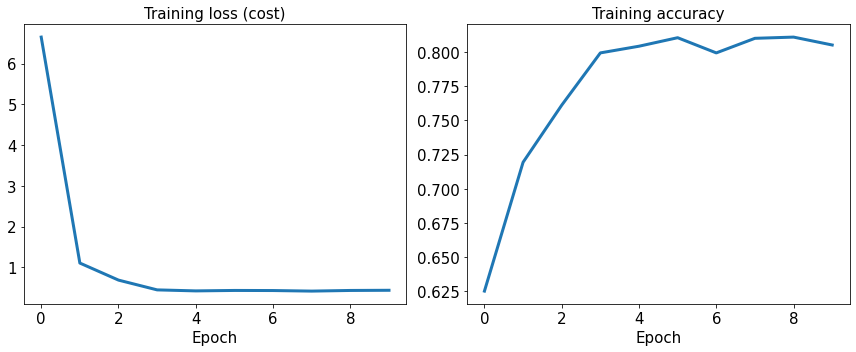

In [111]:
# Plot training cost and accuracy
hist = fit_model_output.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss (cost)', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

**Conclusions**